In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
import random as rn
from scipy.integrate import ode
from scipy.interpolate import interp1d

In [131]:
def get_stimulus(N_pts=300, TR=1, nblocks=5, duration_range=(1,3)):
    '''
    Esta función permite generar los estímulos (el término u del modelo DCM)
    Entradas:
    - N_pts, el número de puntos de la función de estímulos
    - TR, el tiempo de repetición que en este contexto es el período de muestreo (tiempo transcurrido entre dos muestras).
    - nblocks, es el número de bloques presentes en la señal de estímulo.
    - duration_range, es la duración de cada bloque. Cada bloque tiene duración aleatoria entre 1 y 3 períodos de muestreo.

    Salidas:
    - u, la señal de estímulo.
    - timeline, es la línea de tiempo generada de acuerdo al TR y N_pts
    - onsets, son los instantes en los cuales ocurre un estímulo.
    - durations, es la duración de cada bloque de estímulos.

    '''
    timeline = np.arange(0, TR * N_pts, TR)
    time_offset = 10
    possible_onsets = np.arange(time_offset, N_pts-time_offset)
    sep_bwn_ons = 10
    durations = []
    onsets = []
    for i in range(nblocks):
        current_block_duration = rn.randint(duration_range[0], duration_range[1])
        current_onset = rn.choice( possible_onsets )
        onsets.append( current_onset )
        durations.append( current_block_duration )
        possible_onsets = possible_onsets[np.logical_or( possible_onsets < current_onset - sep_bwn_ons,
                                                possible_onsets > current_onset + sep_bwn_ons)]
    u = np.zeros(N_pts)
    for i,d in zip(onsets, durations):
        u[i:i+d] = 1
    return u, timeline, onsets, durations

def hrf(t, tau1=5.4, delta1=6.0, tau2=10.8, delta2=12.0, c=0.35):
    '''
    Esta función genera la función de respuesta hemodinámica (HRF), la respuesta impulso del cerebro en resonancia magnética funcional. Los parámetros de esta función para un sujeto sano son tau1=5.4, delta1=6.0, tau2=10.8, delta2=12.0, c=0.35
    Entradas:
    - t, el vector temporal en los cuales se genera la HRF.
    - tau1=5.4, delta1=6.0, tau2=10.8, delta2=12.0, c=0.35 son los parámetros del a HRF para un sujeto sano.

    Salidas:
    - h, el vector que contiene la HRF para cada instante contenido en t.
    '''

    t = np.copy(t)
    gamma1 = ((t/tau1)**delta1) * np.exp(-(delta1/tau1)*(t-tau1))
    gamma2 = c*((t/tau2)**delta2) * np.exp(-(delta2/tau2)*(t-tau2))
    h = gamma1 - gamma2
    return h

def Hmat(h):

    '''
    Esta función genera la matriz de convolución para la HRF. Al multiplicar esta matriz por vector, el resultado es la convolución de la HRF con la señal que contiene dicho vector. Nota: si H es de tamaño mxm, el vector a multiplicar debe ser de tamaño m.
    Entradas:
    - h, el vector que contiene la HRF.

    Salidas:
    - H, la matriz de convolución generada con h.
    '''

    fr = np.zeros( len(h) )
    fr[0] = h[0]
    H = toeplitz(h, fr)
    return H

In [132]:
### Movimiento sexy con fines educativos
# u = np.zeros(shape=(300, 5))
# for n in range(5):
#     u[:, n], _, _, _ = get_stimulus(TR=1, duration_range=(1, 3))  # Asegúrate que esta función retorna algo adecuado
#
# print(u.shape)

# ORIGINAL

In [133]:
def get_dcm_data(N_nds=5, N_pts=300, TR=1):
    '''
    Esta función genera datos de resonancia magnética funcional usando un DCM.
    Entradas:
    - N_nds, el número de nodos en el DCM.
    - N_pts, el número de puntos temporales de cada nodo.
    - TR, el tiempo de repetición que en este contexto es el período de muestreo (tiempo transcurrido entre dos muestras).

    Salidas:
    - Y, es un diccionario cuyas llaves son los nombres de los nodos y los valores son señales de los nodos correspondientes.
    - U, es un diccionario cuyas llaves son los nombres de los nodos y los valores son estímulos generados para cada nodo.
    - H, es la matriz de convolución usada.
    - timeline, es la línea de tiempo generada de acuerdo al TR y N_pts
    '''

    u = np.zeros(shape=(N_pts, N_nds))
    for n in range(N_nds):
        u[:, n], _, _, _ = get_stimulus(TR=TR, duration_range=(1, 3))  # Asegúrate que esta función retorna algo adecuado
    estimulo = u
    timeline = np.arange(0, TR * N_pts, TR)

    h = hrf(timeline)
    H = Hmat(h)

    A = -np.eye(N_nds)
    A[2,1] = .9
    A[4,1] = .9
    A[3,2] = .9
    A[3,4] = .9

    # acá se resulven las ec. diferenciales de cada nodo.
    X = np.zeros(shape=(N_pts,N_nds))
    dt = np.ones(N_nds)
    for t in range(1,N_pts):
        X[t,:] = X[t-1,:] + dt * ( np.dot(A,X[t-1, :]) + u[t, :] )


    # acá se convolucionan las señales neuronales de cada nodo con la HRF.
    Y = dict()
    U = dict()
    for n in range(N_nds):
        key = 'n'+str(n+1)
        s = np.dot(H, X[:,n])
        s = s - s.mean()
        Y[key] = s / s.std()
        U[key] = u[:,n]

    return Y, U, H, timeline, estimulo



if __name__ == "__main__":

    Y, U, H, timeline, estimulo = get_dcm_data()

In [134]:
Y, U, H, timeline, estimulo = get_dcm_data()

y_list = []
y_r_list = []
u_list = []

for n in Y:

    y = Y[n][np.newaxis, :]
    ruido = y + np.random.randn(*y.shape)
    #y_r_list.append(*y_r.shape)
    uOriginal = U[n][np.newaxis, :]

    y_r_list.append(ruido)
    y_list.append(y)
    u_list.append(uOriginal)
    ## y = y.reshape(1, -1)
    ## y = y.reshape(1, -1)

Y = np.concatenate(y_list)
U = np.concatenate(u_list)
Y_r = np.concatenate(y_r_list)


In [135]:

def add_noise_to_signal(signal, snr):
    """
    Agrega ruido gaussiano a un vector de señal DCM para alcanzar un SNR específico.

    Parámetros:
    - signal (numpy.ndarray): Vector de señales DCM sin ruido.
    - snr (float): Razón señal-ruido deseada, definida como la relación de las
                   desviaciones estándar de la señal y del ruido.

    Retorna:
    - numpy.ndarray: Vector de señales DCM con ruido añadido.
    """
    # Calculamos la desviación estándar de la señal original
    sigma_signal = np.std(signal)

    # Calculamos la desviación estándar del ruido necesario para alcanzar el SNR deseado
    sigma_noise = sigma_signal / snr

    # Generamos ruido gaussiano i.i.d. con media 0 y la desviación estándar calculada
    noise = np.random.normal(0, sigma_noise, signal.shape)

    # Sumamos el ruido a la señal original y retornamos el resultado
    noisy_signal = signal + noise

    return noisy_signal

# Ejemplo de uso
clean_signal = Y  # Una señal sinusoidal simple

# Aplicamos la función con diferentes SNR
noisy_signal_0_2 = add_noise_to_signal(clean_signal, 0.2)
noisy_signal_0_5 = add_noise_to_signal(clean_signal, 0.5)
noisy_signal_1_5 = add_noise_to_signal(clean_signal, 1.5)

# Imprimir una muestra de los resultados para verificar
print("Señal original:", clean_signal)
#print("Señal con SNR 0.2:", noisy_signal_0_2[:10])
#print("Señal con SNR 0.5:", noisy_signal_0_5[:10])
#print("Señal con SNR 1.5:", noisy_signal_1_5[:10])

Señal original: [[-0.20500216 -0.20500216 -0.20500216 ... -0.20500216 -0.20500216
  -0.20500216]
 [-0.18795109 -0.18795109 -0.18795109 ... -0.18795109 -0.18795109
  -0.18795109]
 [-0.26270806 -0.26270806 -0.26270806 ... -0.26294837 -0.26282604
  -0.26276524]
 [-0.37236001 -0.37236001 -0.37236001 ... -0.37260612 -0.37248221
  -0.37241988]
 [-0.27808943 -0.27808943 -0.27808943 ... -0.27808943 -0.27808943
  -0.27808943]]


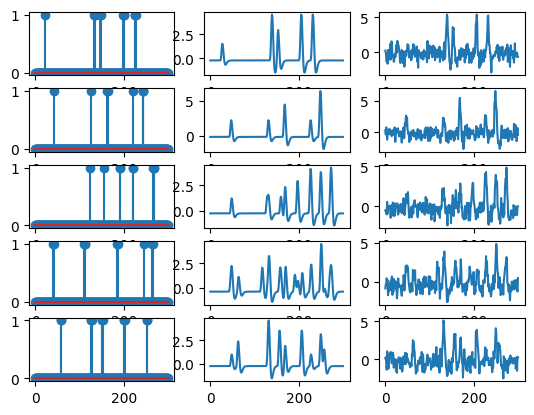

In [136]:
Nnds = Y.shape[0]
fig, axs = plt.subplots(Nnds, 3)
for i in range(Nnds):
    axs[i,0].stem(timeline, U[i, :])
    axs[i,1].plot(timeline, clean_signal[i, :])
    axs[i,2].plot(timeline, noisy_signal_1_5[i, :])

plt.show()

# SOLVER

In [137]:
def solve_ode(A, u, t_points, X0):
    """
    Resuelve el sistema de ecuaciones diferenciales dX/dt = AX + u(t) usando scipy.integrate.ode.

    Args:
    A (ndarray): Matriz constante del sistema.
    u (ndarray): Array de inputs en cada tiempo t.
    t_points (ndarray): Puntos de tiempo en los que se evalúa la solución.
    X0 (ndarray): Condición inicial del sistema.

    Returns:
    ndarray: Solución del sistema en cada tiempo t.
    """
    # Interpolación de la función de entrada u(t)
    u_interp = interp1d(t_points, u, axis=0, fill_value="extrapolate", bounds_error=False)

    # Función que define la derivada de X en el tiempo t
    def model(t, X):
        u_t = u_interp(t)
        dXdt = np.dot(A, X) + u_t
        return dXdt

    # Crear una instancia de `ode` con el modelo
    solver = ode(model).set_integrator('dopri5')  # Puedes usar 'dopri5' (Runge-Kutta 4-5) u otro método
    solver.set_initial_value(X0, t_points[0])

    # Lista para guardar la solución
    sol = [X0]
    # Integrar el sistema a lo largo de los tiempos dados
    for t in t_points[1:]:
        if solver.successful():
            solver.integrate(t)
            sol.append(solver.y)
        else:
            break

    return np.array(sol)

In [138]:
def get_dcm_data2(N_nds=5, N_pts=300, TR=1, u=estimulo):
    timeline = np.arange(0, TR * N_pts, TR)
    h = hrf(timeline)  # Asumimos que esta función está correctamente definida en otro lugar
    H = Hmat(h)  # Asumimos que esta función también está correctamente definida

    A = -np.eye(N_nds)
    A[2, 1] = .9
    A[4, 1] = .9
    A[3, 2] = .9
    A[3, 4] = .9

    X0 = np.zeros(N_nds)  # Condición inicial correcta
    t_points = np.linspace(0, TR * N_pts, N_pts)  # Ajuste del rango de tiempo

    X = solve_ode(A, u, t_points, X0)  # Llamada correcta a la función

    Y = dict()
    U = dict()
    for n in range(N_nds):
        key = 'n' + str(n + 1)
        s = np.dot(H, X[:, n])  # Asegurarse que H y X tienen dimensiones compatibles
        s = s - s.mean()
        Y[key] = s / s.std()
        U[key] = u[:, n]

    return Y, U, H, timeline


In [139]:
Y, U, H, timeline = get_dcm_data2()

y_list = []
y_r_list = []
u_list = []

for n in Y:

    y = Y[n][np.newaxis, :]
    ruido = y + np.random.randn(*y.shape)
    #y_r_list.append(*y_r.shape)
    uputo = U[n][np.newaxis, :]

    y_r_list.append(ruido)
    y_list.append(y)
    u_list.append(uputo)
    ## y = y.reshape(1, -1)
    ## y = y.reshape(1, -1)

Y = np.concatenate(y_list)
U = np.concatenate(u_list)
Y_r = np.concatenate(y_r_list)


In [140]:

def add_noise_to_signal(signal, snr):
    """
    Agrega ruido gaussiano a un vector de señal DCM para alcanzar un SNR específico.

    Parámetros:
    - signal (numpy.ndarray): Vector de señales DCM sin ruido.
    - snr (float): Razón señal-ruido deseada, definida como la relación de las
                   desviaciones estándar de la señal y del ruido.

    Retorna:
    - numpy.ndarray: Vector de señales DCM con ruido añadido.
    """
    # Calculamos la desviación estándar de la señal original
    sigma_signal = np.std(signal)

    # Calculamos la desviación estándar del ruido necesario para alcanzar el SNR deseado
    sigma_noise = sigma_signal / snr

    # Generamos ruido gaussiano i.i.d. con media 0 y la desviación estándar calculada
    noise = np.random.normal(0, sigma_noise, signal.shape)

    # Sumamos el ruido a la señal original y retornamos el resultado
    noisy_signal = signal + noise

    return noisy_signal

# Ejemplo de uso
clean_signal = Y  # Una señal sinusoidal simple

# Aplicamos la función con diferentes SNR
noisy_signal_0_2 = add_noise_to_signal(clean_signal, 0.2)
noisy_signal_0_5 = add_noise_to_signal(clean_signal, 0.5)
noisy_signal_1_5 = add_noise_to_signal(clean_signal, 1.5)

# Imprimir una muestra de los resultados para verificar
print("Señal original:", clean_signal)
#print("Señal con SNR 0.2:", noisy_signal_0_2[:10])
#print("Señal con SNR 0.5:", noisy_signal_0_5[:10])
#print("Señal con SNR 1.5:", noisy_signal_1_5[:10])

Señal original: [[-0.22163351 -0.22163351 -0.22163351 ... -0.22163351 -0.22163351
  -0.22163351]
 [-0.20277292 -0.20277292 -0.20277292 ... -0.20277292 -0.20277292
  -0.20277292]
 [-0.28981241 -0.28981241 -0.28981241 ... -0.29061828 -0.29022602
  -0.29002175]
 [-0.43001228 -0.43001228 -0.43001228 ... -0.4311245  -0.43060503
  -0.4303236 ]
 [-0.30526147 -0.30526147 -0.30526147 ... -0.30526147 -0.30526147
  -0.30526147]]


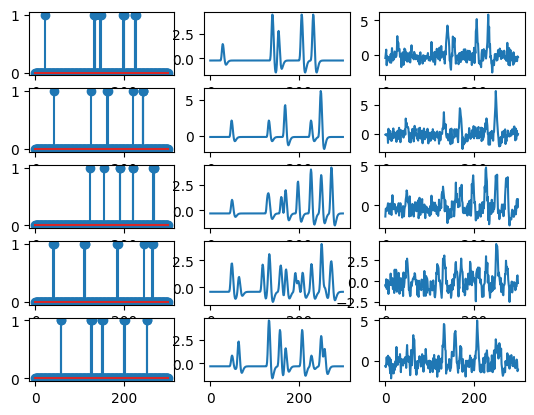

In [141]:
Nnds = Y.shape[0]
fig, axs = plt.subplots(Nnds, 3)
for i in range(Nnds):
    axs[i,0].stem(timeline, U[i, :])
    axs[i,1].plot(timeline, clean_signal[i, :])
    axs[i,2].plot(timeline, noisy_signal_1_5[i, :])

plt.show()